# Random forest classification

**What does this notebook do?** This notebook classifies remote sensing data using a random forest classifier model. Key features include being able to efficiently import training data from a set of point, line or polygon shapefiles (i.e. data is extracted from each shapefile separately to avoid slow `dc.load` on large areas), and allow flexible and consistent selection of training and analysis data using import functions (i.e. ensuring training data is consistent with analysis data). The notebook exports geotiff classification outputs and a series of evaluation figures to help fine-tune the classifier.

**Date:** April 2018

**Author:** Robbi Bishop-Taylor

## Import modules and define functions

In [10]:
# Load modules
import datacube
import os
import sys
import warnings
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.image as mpimg
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from datacube_stats.statistics import GeoMedian

# # Import DEA Notebooks scripts
sys.path.append(os.path.abspath('/g/data/u46/users/ck9738/dea-notebooks/Algorithms/'))
from ClassificationTools import randomforest_train
from ClassificationTools import randomforest_classify
from ClassificationTools import randomforest_eval
from DEADataHandling import tasseled_cap
from DEADataHandling import load_nbarx

# For nicer notebook plotting, hide warnings (comment out for real analysis)
warnings.filterwarnings('ignore') 

# Set up datacube instance
dc = datacube.Datacube()


s2aws = Datacube(config='/home/547/ck9738/datacube-s2.conf')

NameError: name 'Datacube' is not defined

## Functions used to import training and analysis data
These functions import datacube data using a query, and return an xarray dataset with one time-step, multiple bands/variables and `crs` and `affine` attributes. 
This format is required as an input to both `randomforest_train` and `randomforest_classify` to ensure that both training and analysis data are consistent.

In [4]:
def hltc_import(query):
    
    """
    Imports high and low composite data for a given spatial query, and
    return an xarray dataset with 'crs' and 'affine' attributes 
    
    :attr query: spatial query for datacube.load()
    :returns: xarray dataset with 'crs' and 'affine' attributes
    """

    # Import data
    low_tide = dc.load(product = 'low_tide_comp_20p', **query)
    high_tide = dc.load(product = 'high_tide_comp_20p', **query)

    # Rename variables in each high/low composite so datasets can be merged
    data_vars = list(low_tide.data_vars)
    low_tide.rename({var: "lt_" + var for var in data_vars}, inplace = True)
    high_tide.rename({var: "ht_" + var for var in data_vars}, inplace = True)

    # Combine into one dataset
    output_xarray = xr.auto_combine([low_tide, high_tide]).isel(time = 0)
    
    # Set attributes   
    output_xarray.attrs['crs'] = low_tide.crs
    output_xarray.attrs['affine'] = low_tide.affine 
    
    return output_xarray


def tc_import(query):
    
    '''
    Wrapper around load_nbarx and tasseled_cap to return an xarray dataset with 
    'crs' and 'affine' attributes
    
    :attr query: query for datacube call; for training, supply only
    non-spatial queries as spatial are generated from training data
    :returns: xarray dataset with 'crs' and 'affine' attributes
    '''
    
    # Import cleaned Landsat bands data
    nbart_data, _, _ = load_nbarx(dc, "ls8", query)
    
    # Compute tasseled cap indices and take median of multiple timesteps
    output_xarray = tasseled_cap(sensor_data = nbart_data, 
                                 sensor = 'ls8',
                                 drop = True).median("time", keep_attrs = True)
    
    return output_xarray   


def nbart_import(query):
    
    '''
    Takes median of a set of nbart Landsat data; could be replaced with geomedian or any other 
    temporal aggregation method
    
    :attr query: query for datacube call; for training, supply only
    non-spatial queries as spatial are generated from training data
    :returns: xarray dataset with 'crs' and 'affine' attributes
    '''
    
    # Import cleaned Landsat bands data
    nbart_data, _, _ = load_nbarx(dc, "ls8", query)
    
    # Combine into one temporally aggregated layer
    aggregated_data = nbart_data.median(dim = "time", keep_attrs = True)
    
    return aggregated_data


## Set up analysis
Defines parameters used for analysis. This notebook contains example analyses for three classification tasks: classifying mangroves using high-low tide composites (HLTC), tasseled cap classification and classification of water vs non-water using median Landsat nbart data. Run one of the cells below to select the desired analysis.

In [ ]:
###########################################
# For HLTC-based mangrove classification: #
###########################################

# Working directory
os.chdir("/g/data/u46/users/ck9738/Random_forest")

# List of training files to import. Shapefiles can be either points, lines or polygons, 
# but must be in the same projection system as the remote sensing dataset being analysed. 
# Each file should cover a small enough spatial area so as to not slow dc.load function 
# excessively (e.g. 100 x 100km max)
train_shps = ["raw_data/train/training_data_mangrove.shp",
              "raw_data/train/training_data_mangrove1.shp",
              "raw_data/train/training_data_mangrove2.shp",
              "raw_data/train/training_data_mangrove3.shp"]

# Output path for classified geotiff
classification_output = "output_data/classification_dc_mangrove.tif"

# Optional dict to re-map training shapefile classes; useful for combining classes
# ('3:2' re-maps class 3 to class 2)
# train_reclass = {1:1, 2:2, 3:2, 4:2}
train_reclass = None

# Names of output classification classes
# classification_names = ["mangrove", "other"]
classification_names = ["mangrove", "water", "veg", "other"]

# Set data function used to import data and optional parameters (e.g. time for temporal data).
# For example, 'tc_import' needs an additional 'time' query as it draws on Landsat time-series 
# data, while 'hltc_import' uses high-low tide composites that have no temporal dimension
data_func = hltc_import
data_func_params = {}


In [ ]:
##########################################
# For Tasseled cap-based classification: #
##########################################

# Working directory
os.chdir("/g/data/r78/rt1527/random_forest")

# List of training files to import. Shapefiles can be either points, lines or polygons, 
# but must be in the same projection system as the remote sensing dataset being analysed. 
# Each file should cover a small enough spatial area so as to not slow dc.load function 
# excessively (e.g. 100 x 100km max)
train_shps = ["raw_data/train/training_data_tasseledcap.shp"]

# Output path for classified geotiff
classification_output = "output_data/classification_dc_tasseledcap.tif"

# Optional dict to re-map training shapefile classes; useful for combining classes
# ('3:2' re-maps class 3 to class 2)
train_reclass = None

# Names of output classification classes
classification_names = ["wetland", "escarpment", "plateau", "other_wetland"]

# Set data function used to import data and optional parameters (e.g. time for temporal data).
# For example, 'tc_import' needs an additional 'time' query as it draws on Landsat time-series 
# data, while 'hltc_import' uses high-low tide composites that have no temporal dimension
data_func = tc_import
data_func_params = {'time': ('2017-03-01', '2017-06-28')}


In [5]:
#####################################################
# For water/non water classification using Landsat: #
#####################################################

# Working directory
os.chdir("/g/data/u46/users/ck9738/Random_forest")

# List of training files to import. Shapefiles can be either points, lines or polygons, 
# but must be in the same projection system as the remote sensing dataset being analysed. 
# Each file should cover a small enough spatial area so as to not slow dc.load function 
# excessively (e.g. 100 x 100km max)
train_shps = ["raw_data/train_water/training_data_waternonwater.shp"]

# Output path for classified geotiff
classification_output = "output_data/classification_dc_waternonwater.tif"

# Optional dict to re-map training shapefile classes; useful for combining classes
# ('3:2' re-maps class 3 to class 2)
train_reclass = None

# Names of output classification classes
classification_names = ["water", "nonwater"]

# Set data function used to import data and optional parameters (e.g. time for temporal data).
# For example, 'tc_import' needs an additional 'time' query as it draws on Landsat time-series 
# data, while 'hltc_import' uses high-low tide composites that have no temporal dimension
data_func = nbart_import
data_func_params = {'time': ('2017-03-01', '2017-06-28')}


## Import training data and fit model
Uses `randomforest_train` to extract training data from potentially multiple training shapefiles, and returns a trained classifier (and optionally, training label and training sample arrays)

In [6]:
# Dict of classifier parameters
classifier_params = {'n_jobs': -1,                                    
                     'n_estimators': 100,
                     'max_features': "auto",
                     'min_samples_leaf': 1,
                     'oob_score': True }

# Extract training data for each training shapefile and train classifier
classifier, train_lab, train_samp = randomforest_train(train_shps = train_shps,
                                                       train_field = "class",
                                                       data_func = data_func,
                                                       data_func_params = data_func_params,
                                                       classifier_params = classifier_params,
                                                       train_reclass = train_reclass)


Importing training data from raw_data/train_water/training_data_waternonwater.shp:
{'x': (-104200.12797711749, -132981.8946159188), 'y': (-1278352.9282547852, -1325088.9074965029), 'crs': 'EPSG:3577', 'time': ('2017-03-01', '2017-06-28')}
Loading ls8_nbart_albers


Failed to resolve driver datacube.plugins.io.read::s3aio
Failed to resolve driver datacube.plugins.io.read::s3aio_test


Loaded ls8_nbart_albers
Generating mask ls8_pq_albers
Masked ls8_nbart_albers with ls8_pq_albers and filtered terrain

Training random forest classifier...
Model trained on 7 bands and 178222 training samples


## Import analysis data and classify
Classifies and exports an analysis dataset using a previously trained random forest classifier, provided this dataset has the same number of bands/variables as the data used to train the classifier. Using the same data function used to train the classifier (e.g. `data_func` previously defined as either `tc_import`, `hltc_import` or `nbart_import`) will ensure this is the case. By setting `class_prob = True`, you can optionally export a geotiff of predicted class probabilities in addition to the classification output.

Loading ls8_nbart_albers
Loaded ls8_nbart_albers
Generating mask ls8_pq_albers
Masked ls8_nbart_albers with ls8_pq_albers and filtered terrain
Data to classify:
  Rows: 2401
  Columns: 2401
  Bands: 7

Classification processing...
  9467 nodata cells removed
  Classification exported

Class probability processing...
  Class probability exported


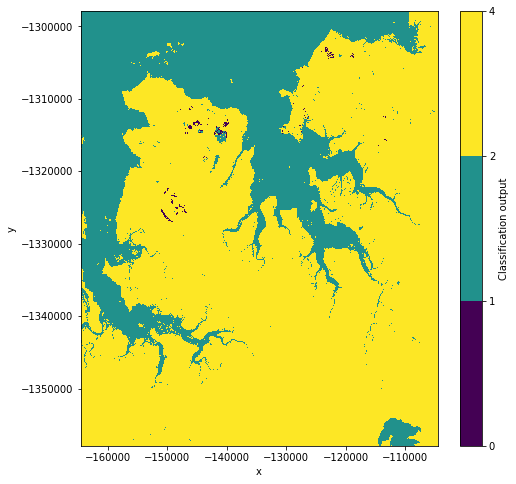

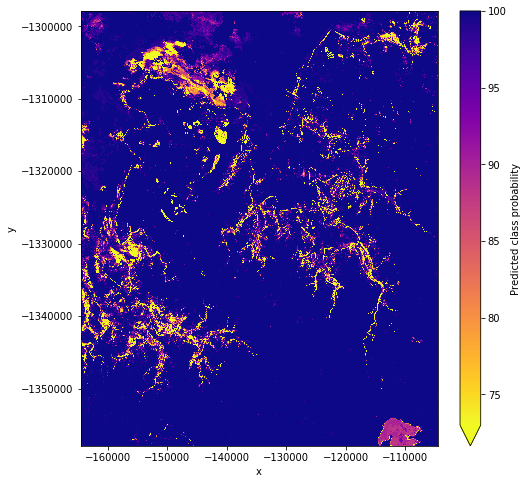

In [7]:
# Set up analysis data query
lat_point, lon_point, buffer = -12.5798399926, 130.782907919, 30000
# lat_point, lon_point, buffer = -12.5693189393, 135.033955268, 20000
x, y = geometry.point(lon_point, lat_point, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),         
         'crs': 'EPSG:3577',
          **data_func_params}

# Load data from datacube
analysis_xarray = data_func(query)

# Run classification and export to file   
class_array, prob_array = randomforest_classify(classifier = classifier,
                                                analysis_data = analysis_xarray,
                                                classification_output = classification_output,
                                                class_prob = True)


# Plot output classification
class_xarray = xr.DataArray(class_array, 
                   coords = [analysis_xarray.y, analysis_xarray.x], 
                   dims = ['y', 'x'],
                   name = "Classification output")
class_xarray.plot(levels = list(np.unique(class_array)) + [len(np.unique(class_array)) + 1], 
                  figsize = (8, 8))

# Plot predicted class probability (proportion of trees agreeing with classification)
plt.plot()
prob_xarray = xr.DataArray(prob_array, 
                           coords = [analysis_xarray.y, analysis_xarray.x], 
                           dims = ['y', 'x'],
                           name = "Predicted class probability")
prob_xarray.plot(cmap = "plasma_r",  
                 vmin = np.percentile(prob_array, 3), 
                 vmax = np.percentile(prob_array, 97),
                 figsize = (8, 8))


## Feature/band/variable importance
Extract classifier estimates of the relative importance of each band/variable for training the classifier. Useful for potentially selecting a subset of input bands/variables for model training/classification (i.e. optimising feature space)

,importance
variable,
coastal_aerosol,0.044917
blue,0.118601
green,0.005437
red,0.048451
nir,0.328025
swir1,0.283141
swir2,0.171427


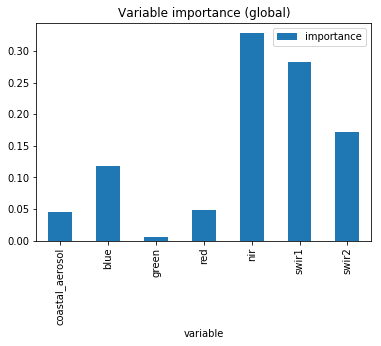

In [8]:
#  Extract feature importances from trained classifier
importance = classifier.feature_importances_
importance_df = pd.DataFrame({'variable': analysis_xarray.data_vars,
                              'importance': importance})
importance_df.set_index("variable", inplace = True)
importance_df.plot.bar(title = "Variable importance (global)")
display(importance_df)


## Plot performance of model by parameter values
Random forest classifiers contain many modifiable parameters that can strongly affect the performance of the model. This section evaluates the effect of these parameters by plotting out-of-bag (OOB) error for a set of classifier parameter scenarios, and exports the resulting plots to file.

FileNotFoundError: [Errno 2] No such file or directory: 'figures/random_forest_params_1.png'

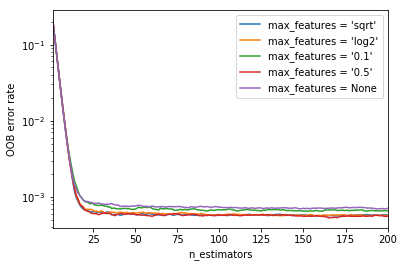

In [9]:
# Test effect of max features
classifier_scenario1 = [("max_features = 'sqrt'",
                        RandomForestClassifier(warm_start = True,
                                               oob_score = True,
                                               max_features = "sqrt")),
                       ("max_features = 'log2'",
                        RandomForestClassifier(warm_start = True, 
                                               oob_score = True,
                                               max_features = "log2")),
                        
                       ("max_features = '0.1'",
                        RandomForestClassifier(warm_start = True, 
                                               max_features = 0.1,
                                               oob_score = True)),
                        
                       ("max_features = '0.5'",
                        RandomForestClassifier(warm_start = True, 
                                               max_features = 0.5,
                                               oob_score = True)),
                       ("max_features = None",
                        RandomForestClassifier(warm_start = True,
                                               max_features = None,
                                               oob_score = True))]

# Test effect of minimum samples per leaf
classifier_scenario2 = [("Leaf = 1",
                         RandomForestClassifier(warm_start = True,
                                                min_samples_leaf = 1,
                                                oob_score = True)),                       
                       ("Leaf = 10",
                        RandomForestClassifier(warm_start = True,
                                               min_samples_leaf = 10,
                                               oob_score = True)),                       
                       ("Leaf = 20",
                        RandomForestClassifier(warm_start = True, 
                                               min_samples_leaf = 20,
                                               oob_score = True)),
                       ("Leaf = 40",
                        RandomForestClassifier(warm_start = True, 
                                               min_samples_leaf = 40,
                                               oob_score = True))]

# Test effect of max depth
classifier_scenario3 = [("Max depth = 1",
                         RandomForestClassifier(warm_start = True,
                                                max_depth = 1,
                                                oob_score = True)),                       
                       ("Max depth = 2",
                        RandomForestClassifier(warm_start = True,
                                               max_depth = 2,
                                               oob_score = True)),                       
                       ("Max depth = 5",
                        RandomForestClassifier(warm_start = True, 
                                               max_depth = 5,
                                               oob_score = True)),                       
                       ("Max depth = 10",
                        RandomForestClassifier(warm_start = True, 
                                               max_depth = 10,
                                               oob_score = True))]

# Test effect of max leaf node
classifier_scenario4 = [("Max leaf node = 5",
                         RandomForestClassifier(warm_start = True,
                                                max_leaf_nodes = 5,
                                                oob_score = True)),                       
                       ("Max leaf node = 10",
                        RandomForestClassifier(warm_start = True,
                                               max_leaf_nodes = 10,
                                               oob_score = True)),                       
                       ("Max leaf node = 20",
                        RandomForestClassifier(warm_start = True, 
                                               max_leaf_nodes = 20,
                                               oob_score = True)),                       
                       ("Max leaf node = 40",
                        RandomForestClassifier(warm_start = True, 
                                               max_leaf_nodes = 40,
                                               oob_score = True))]

# Test effect of max leaf node
classifier_scenario5 = [("Min samples split = 5",
                         RandomForestClassifier(warm_start = True,
                                                min_samples_split = 5,
                                                oob_score = True)),                       
                       ("Min samples split = 10",
                        RandomForestClassifier(warm_start = True,
                                               min_samples_split = 10,
                                               oob_score = True)),                       
                       ("Min samples split = 20",
                        RandomForestClassifier(warm_start = True, 
                                               min_samples_split = 20,
                                               oob_score = True)),                       
                       ("Min samples split = 40",
                        RandomForestClassifier(warm_start = True, 
                                               min_samples_split = 40,
                                               oob_score = True))]

# Produce figures and export plots for each set of classification scenarios
for i, classifier_scenario in enumerate([classifier_scenario1, 
                                         classifier_scenario2, 
                                         classifier_scenario3,
                                         classifier_scenario4,
                                         classifier_scenario5]):
    
    # Plot OOB error by classifier scenario
    randomforest_eval(training_labels = train_lab, 
                      training_samples = train_samp, 
                      classifier_scenario = classifier_scenario,
                      output_path = "figures/random_forest_params_{}.png".format(i + 1),
                      max_estimators = 200)   


## Export tree diagrams
Export .png plots of each decision tree in the random forest ensemble. Useful for inspecting the splits used by the classifier to classify the data.

In [ ]:
# Plot output random forest trees to file
for n, tree_in_forest in enumerate(classifier.estimators_):    

    # Create graph and save to dot file
    export_graphviz(tree_in_forest,
                    out_file = "figures/tree_graphs/tree.dot",
                    feature_names = list(analysis_xarray.data_vars),
                    class_names = classification_names,
                    filled = True,
                    rounded = True)

    # Plot as figure
    os.system('dot -Tpng figures/tree_graphs/tree.dot -o ' + \
              'figures/tree_graphs/tree' + str(n + 1) + '.png')    
    
# Plot first resulting tree
img = mpimg.imread('figures/tree_graphs/tree1.png')
plt.figure(figsize = (15,12))
plt.imshow(img, interpolation = "bilinear")
plt.show()
